In [1]:
import wandb
import torch
import yaml
from ecallisto_model import (
    ResNet18,
    create_normalize_function,
    create_unnormalize_function,
)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from ecallisto_dataset import (
    EcallistoDatasetBinary,
)
checkpoint_reference = "vincenzo-timmel/FlareSense-v2/model-aen4kqj5:best"

api = wandb.Api()
artifact = api.artifact(checkpoint_reference)
artifact_dir = artifact.download()

wandb: Downloading large artifact model-aen4kqj5:best, 128.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


In [2]:
model = ResNet18(2)

In [3]:
checkpoint = torch.load('artifacts\model-aen4kqj5-v74\model.ckpt', map_location='cpu')

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\vince\AppData\Local\Temp\ipykernel_17296\2068959946.py:1: SyntaxWarning: invalid escape sequence '\m'
  checkpoint = torch.load('artifacts\model-aen4kqj5-v74\model.ckpt', map_location='cpu')


In [4]:
# load checkpoint
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
from datasets import DatasetDict, load_dataset
ds = load_dataset("i4ds/radio-sunburst-ecallisto")

In [6]:
dd = DatasetDict()
dd["train"] = ds["train"]
dd["test"] = ds["test"]
dd["validation"] = ds["validation"]

In [7]:
# Define normalization
base_transform = Compose(
    [
        Resize([224, 224]),  # Resize the image
    ]
)

with open("antenna_stats.yaml", "r") as file:
    antenna_stats = yaml.safe_load(file)
normalize_transform = create_normalize_function(
    antenna_stats=antenna_stats, simple=False
)

In [8]:
ds_train = EcallistoDatasetBinary(
    dd["train"],
    base_transform=base_transform,
    normalization_transform=normalize_transform,
)
ds_valid = EcallistoDatasetBinary(
    dd["validation"],
    base_transform=base_transform,
    normalization_transform=normalize_transform,
)
ds_test = EcallistoDatasetBinary(
    dd["test"],
    base_transform=base_transform,
    normalization_transform=normalize_transform,
)


In [9]:
train_dataloader = DataLoader(
    ds_train,
    batch_size=32,
    shuffle=False,
    persistent_workers=False,
)

val_dataloader = DataLoader(
    ds_valid,
    batch_size=32,
    shuffle=False,
    persistent_workers=False,
)

test_dataloader = DataLoader(
    ds_test,
    batch_size=32,
    shuffle=False,  # To randomly log images
    persistent_workers=False,
)

In [295]:
model.eval()  # Ensure the model is in evaluation mode
from tqdm import tqdm
import os
import pandas as pd

data = []  # To store all the information

# Send all to device
model.to('cuda')
class_1_prob = []
with torch.no_grad():
    for inputs, labels, antennas, datetimes in tqdm(test_dataloader):
        logits = model(inputs.to('cuda'))
        probs = torch.softmax(logits, dim=1)

        for idx in range(inputs.shape[0]):
            class_1_prob.append(probs[idx][1].detach().cpu().item())



# Function to sanitize datetime string for use in filenames
def sanitize_filename(filename):
    return filename.replace(":", "_").replace(" ", "_")

# Base directory where you want to save the images
image_dir = 'test_images'
os.makedirs(image_dir, exist_ok=True)

# List to store metadata for each image
metadata = []

for prob, item in tqdm(zip(class_1_prob, dd['test']), total=len(class_1_prob)):
    # Construct the folder path for the current item
    label = "1" if item['label'] > 0 else "0"
    folder_path = os.path.join(image_dir, label)
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    
    # Round prob
    prob = str(int(prob*1000))
    # Sanitize the filename and construct the full filepath
    filename = sanitize_filename(f"{prob}_{item['antenna']}_{item['datetime']}.png")
    filepath = os.path.join(folder_path, filename)
    
    # Convert image data to a PIL Image and save
    img = item['image']
    img.save(filepath)
    
    # Collect metadata and image path
    metadata.append({
        'antenna': item['antenna'],
        'label': item['label'],
        'datetime': item['datetime'],
        'image_path': filepath
    })

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame(metadata)

# Save the DataFrame to a CSV file
csv_path = os.path.join(image_dir, 'metadata.csv')
metadata_df.to_csv(csv_path, index=False)


100%|██████████| 14271/14271 [01:43<00:00, 138.39it/s]


In [296]:
model.eval()  # Ensure the model is in evaluation mode
from tqdm import tqdm
import os
import pandas as pd

data = []  # To store all the information

# Send all to device
model.to('cuda')
class_1_prob = []
with torch.no_grad():
    for inputs, labels, antennas, datetimes in tqdm(val_dataloader):
        logits = model(inputs.to('cuda'))
        probs = torch.softmax(logits, dim=1)

        for idx in range(inputs.shape[0]):
            class_1_prob.append(probs[idx][1].detach().cpu().item())



# Function to sanitize datetime string for use in filenames
def sanitize_filename(filename):
    return filename.replace(":", "_").replace(" ", "_")

# Base directory where you want to save the images
image_dir = 'val_images'
os.makedirs(image_dir, exist_ok=True)

# List to store metadata for each image
metadata = []

for prob, item in tqdm(zip(class_1_prob, dd['validation']), total=len(class_1_prob)):
    # Construct the folder path for the current item
    label = "1" if item['label'] > 0 else "0"
    folder_path = os.path.join(image_dir, label)
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    
    # Round prob
    prob = str(int(prob*1000))
    # Sanitize the filename and construct the full filepath
    filename = sanitize_filename(f"{prob}_{item['antenna']}_{item['datetime']}.png")
    filepath = os.path.join(folder_path, filename)
    
    # Convert image data to a PIL Image and save
    img = item['image']
    img.save(filepath)
    
    # Collect metadata and image path
    metadata.append({
        'antenna': item['antenna'],
        'label': item['label'],
        'datetime': item['datetime'],
        'image_path': filepath
    })

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame(metadata)

# Save the DataFrame to a CSV file
csv_path = os.path.join(image_dir, 'metadata.csv')
metadata_df.to_csv(csv_path, index=False)


100%|██████████| 14253/14253 [01:53<00:00, 125.15it/s]


In [297]:
model.eval()  # Ensure the model is in evaluation mode
from tqdm import tqdm
import os
import pandas as pd

data = []  # To store all the information

# Send all to device
model.to('cuda')
class_1_prob = []
with torch.no_grad():
    for inputs, labels, antennas, datetimes in tqdm(train_dataloader):
        logits = model(inputs.to('cuda'))
        probs = torch.softmax(logits, dim=1)

        for idx in range(inputs.shape[0]):
            class_1_prob.append(probs[idx][1].detach().cpu().item())



# Function to sanitize datetime string for use in filenames
def sanitize_filename(filename):
    return filename.replace(":", "_").replace(" ", "_")

# Base directory where you want to save the images
image_dir = 'train_images'
os.makedirs(image_dir, exist_ok=True)

# List to store metadata for each image
metadata = []

for prob, item in tqdm(zip(class_1_prob, dd['train']), total=len(class_1_prob)):
    # Construct the folder path for the current item
    label = "1" if item['label'] > 0 else "0"
    folder_path = os.path.join(image_dir, label)
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    
    # Round prob
    prob = str(int(prob*1000))
    # Sanitize the filename and construct the full filepath
    filename = sanitize_filename(f"{prob}_{item['antenna']}_{item['datetime']}.png")
    filepath = os.path.join(folder_path, filename)
    
    # Convert image data to a PIL Image and save
    img = item['image']
    img.save(filepath)
    
    # Collect metadata and image path
    metadata.append({
        'antenna': item['antenna'],
        'label': item['label'],
        'datetime': item['datetime'],
        'image_path': filepath
    })

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame(metadata)

# Save the DataFrame to a CSV file
csv_path = os.path.join(image_dir, 'metadata.csv')
metadata_df.to_csv(csv_path, index=False)


 22%|██▏       | 786/3545 [01:19<05:23,  8.54it/s]

In [15]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
from PIL import Image

In [268]:
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers = [model.resnet18.layer4[-1]])

In [271]:
targets = [ClassifierOutputTarget(1)]

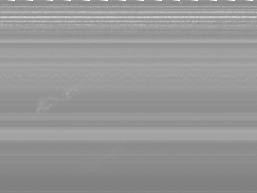

In [291]:
IDX = 795
dd['test'][IDX]['image']

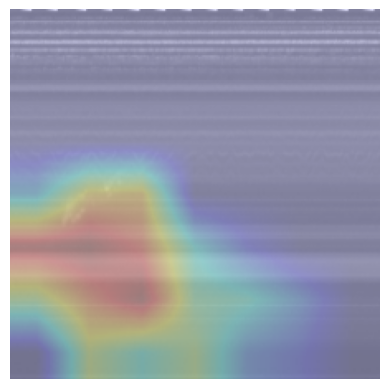

In [293]:

# Correctly resize image to 224x224
resized_image = np.array(dd['test'][IDX]['image'].convert('RGB').resize((224, 224), Image.BILINEAR)) / 255

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=ds_test[IDX][0].unsqueeze(0), targets=targets)[0, :]

# Assuming grayscale_cam is correctly sized (224x224) but needs to be expanded for RGB overlay
# Normalize grayscale_cam for better visualization
grayscale_cam_normalized = grayscale_cam - np.min(grayscale_cam)
grayscale_cam_normalized = grayscale_cam_normalized / np.max(grayscale_cam_normalized)

# Expand grayscale_cam to have 3 channels
grayscale_cam_expanded = np.repeat(grayscale_cam_normalized[:, :, np.newaxis], 3, axis=2)

# Overlay grayscale_cam on resized_image
visualization = show_cam_on_image(resized_image, grayscale_cam_expanded, use_rgb=True, image_weight=0.8)

import matplotlib.pyplot as plt

# Assuming 'visualization' is your final overlay image
plt.imshow(visualization)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

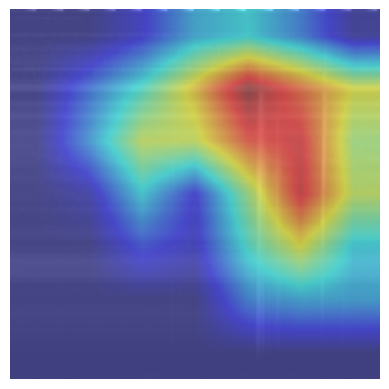

In [273]:
IDX = 802
dd['test'][IDX]['image']
# Correctly resize image to 224x224
resized_image = np.array(dd['test'][IDX]['image'].convert('RGB').resize((224, 224), Image.BILINEAR)) / 255

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=ds_test[IDX][0].unsqueeze(0), targets=targets)[0, :]

# Assuming grayscale_cam is correctly sized (224x224) but needs to be expanded for RGB overlay
# Normalize grayscale_cam for better visualization
grayscale_cam_normalized = grayscale_cam - np.min(grayscale_cam)
grayscale_cam_normalized = grayscale_cam_normalized / np.max(grayscale_cam_normalized)

# Expand grayscale_cam to have 3 channels
grayscale_cam_expanded = np.repeat(grayscale_cam_normalized[:, :, np.newaxis], 3, axis=2)

# Overlay grayscale_cam on resized_image
visualization = show_cam_on_image(resized_image, grayscale_cam_expanded, use_rgb=True)

import matplotlib.pyplot as plt

# Assuming 'visualization' is your final overlay image
plt.imshow(visualization)
plt.axis('off')  # Remove axis ticks and labels
plt.show()